# FixationGrower Initial Plots

**Goal**: Given new trials table, see how multi-day plotting works with FixationGrower protocol and make any updates as needed. 

**Notes**: May need to consider making a new visualization class for this purpose, or at least some visualization logic that utilizes the "protocol" field of the trials table.

In [19]:
import sys

sys.path.append("../")

import behav_viz.ingest as ingest
import behav_viz.visualize as viz


import seaborn as sns
import matplotlib.pyplot as plt
from behav_viz.utils import plot_utils as pu
sns.set_context("talk")


%load_ext autoreload
%autoreload 2   

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
animal_id = ["R010"]
date_min = "2024-07-19"

# Create a dataframe with all the trials
trials_df = ingest.create_trials_df.create_trials_df_from_dj(animal_id, date_min)
days_df = ingest.create_days_df.create_days_df_from_dj(animal_id, date_min)

animal_id R010
Fetched 11 dates from Sessions table from 2024-07-19 to 2024-07-29 for R010



# Summaries over days

In [5]:
for (date, animal_id), sub_df in trials_df.groupby(["date", "animal_id"]):
    pass

What it would look like with old DMS2 protocol:

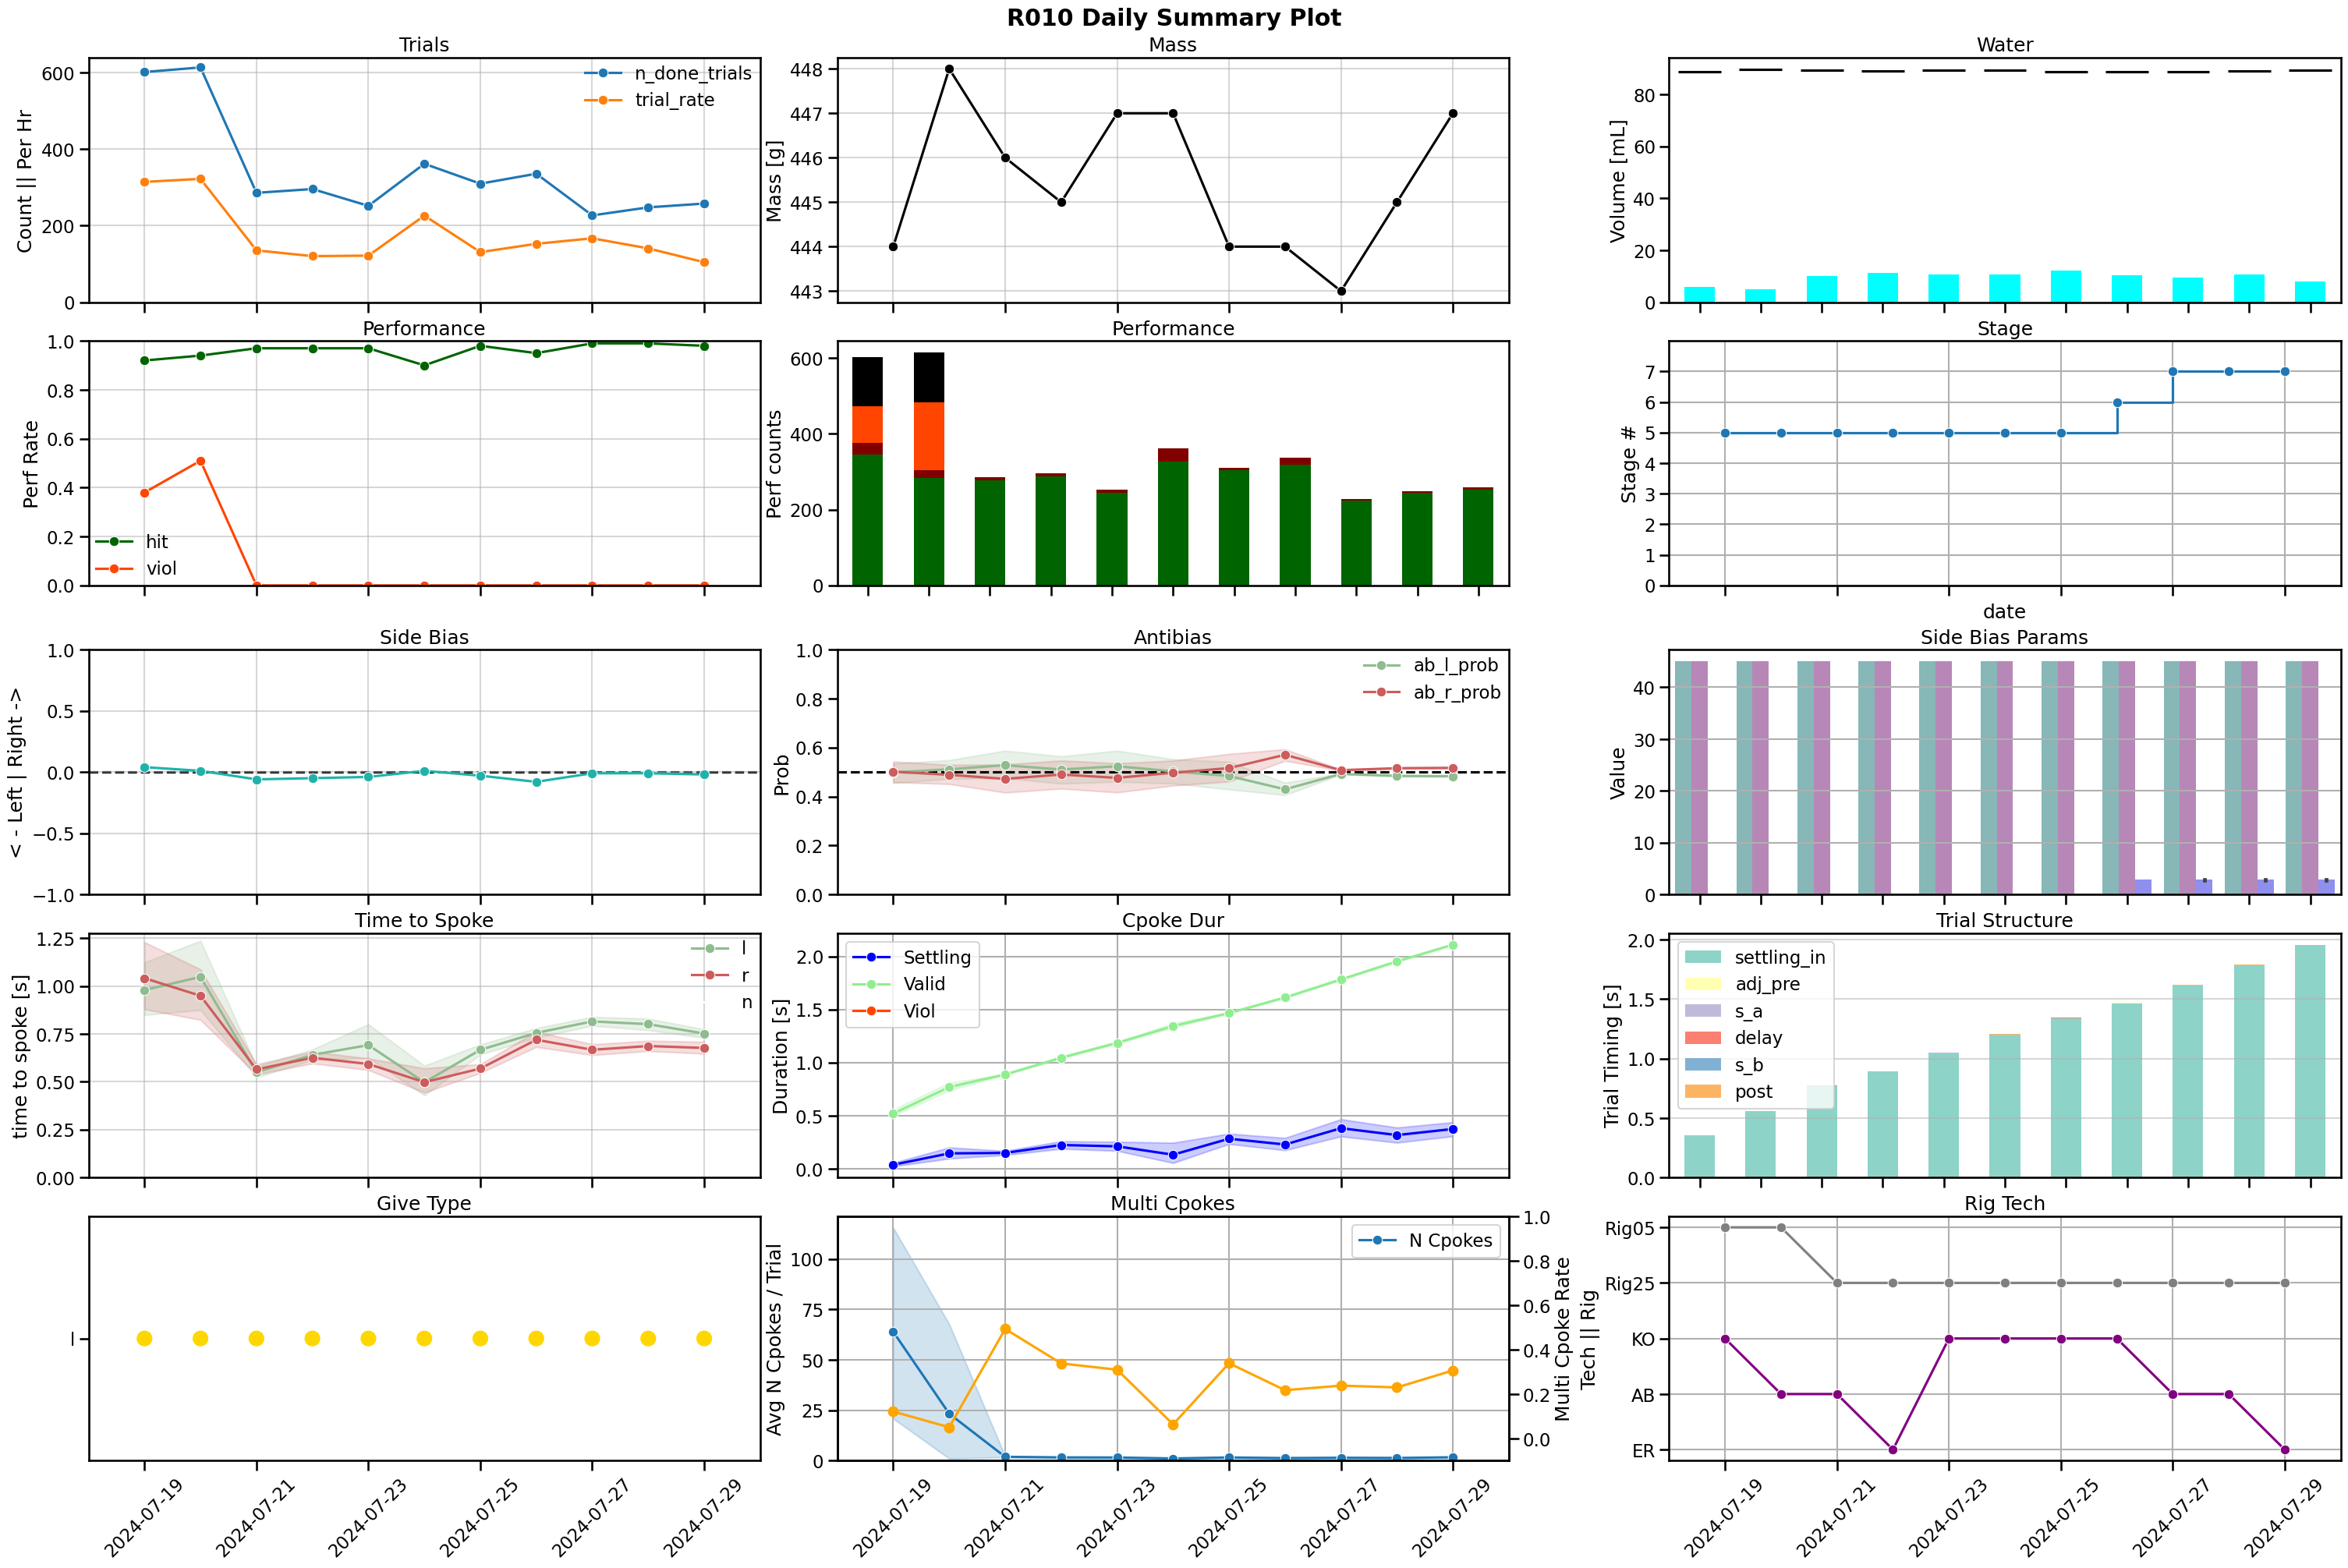

In [6]:
viz.summarize.over_days_summaries(animal_id, days_df, trials_df)

New version for cpoking:


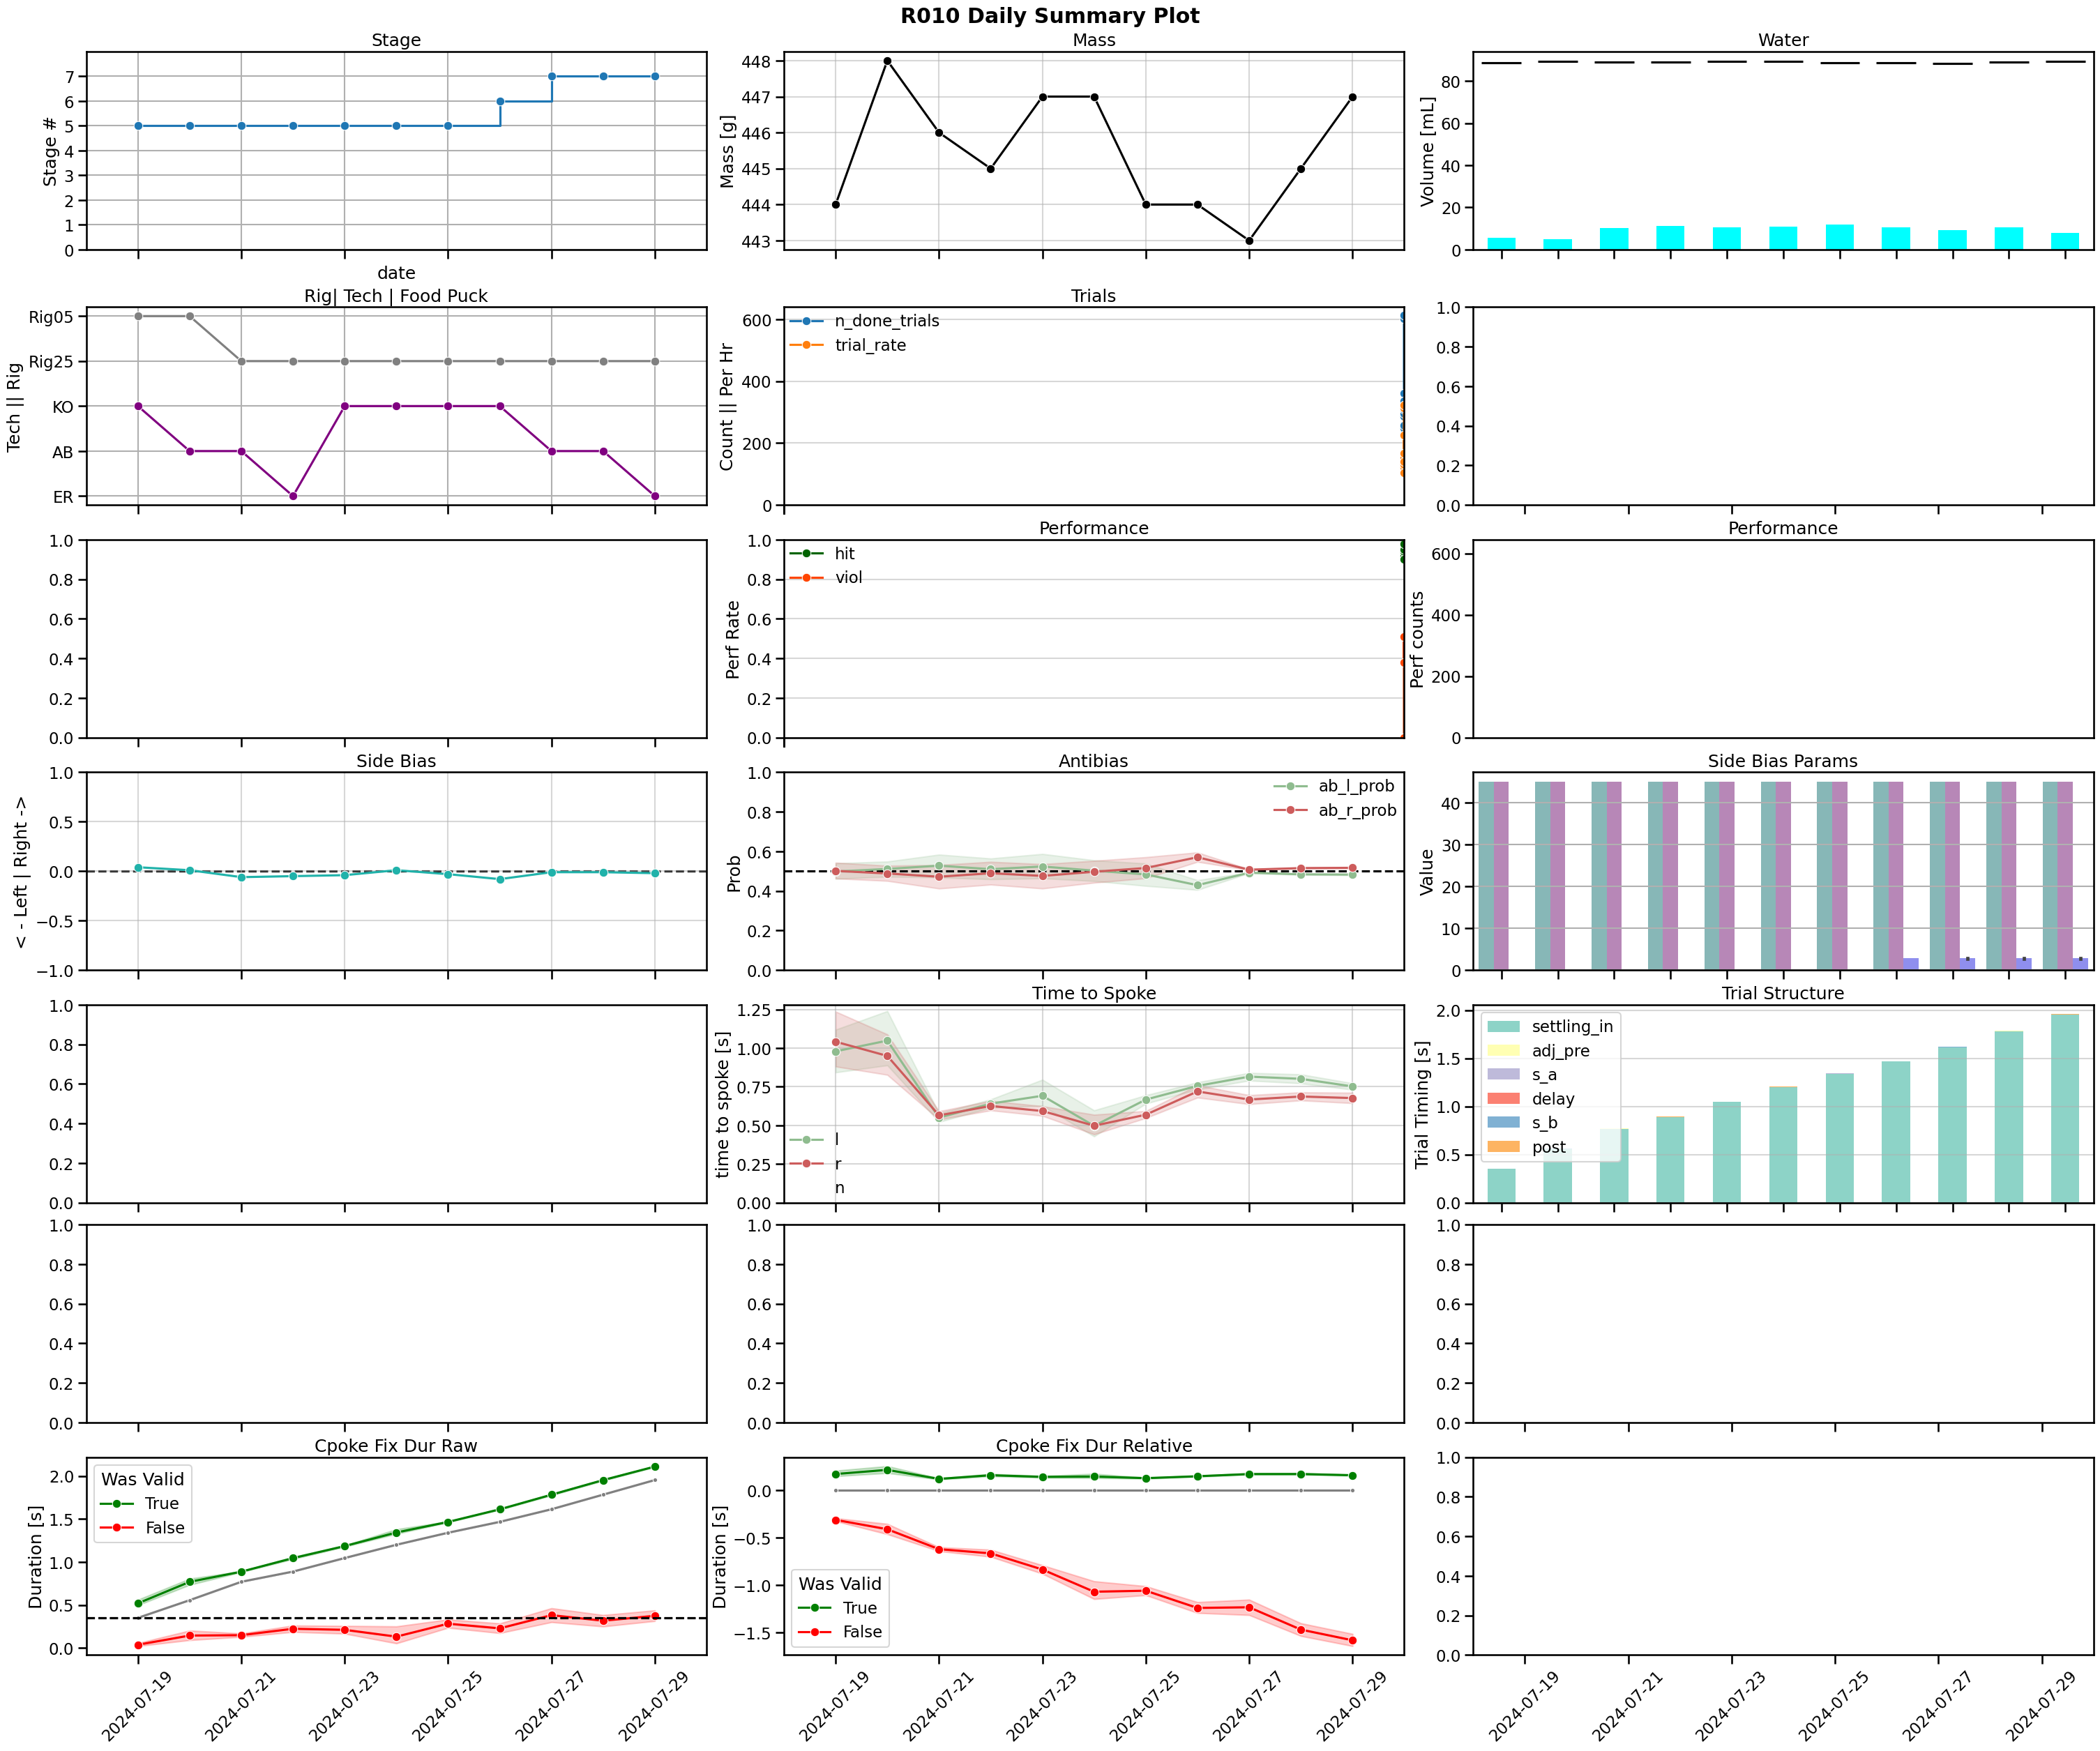

In [16]:
viz.FixationGrower.multiplots.over_days_summary_cpoke_learning(
    animal_id, days_df, trials_df
)

### Single Plot Dev


#### Plot Rig/Tech/Foodpuck

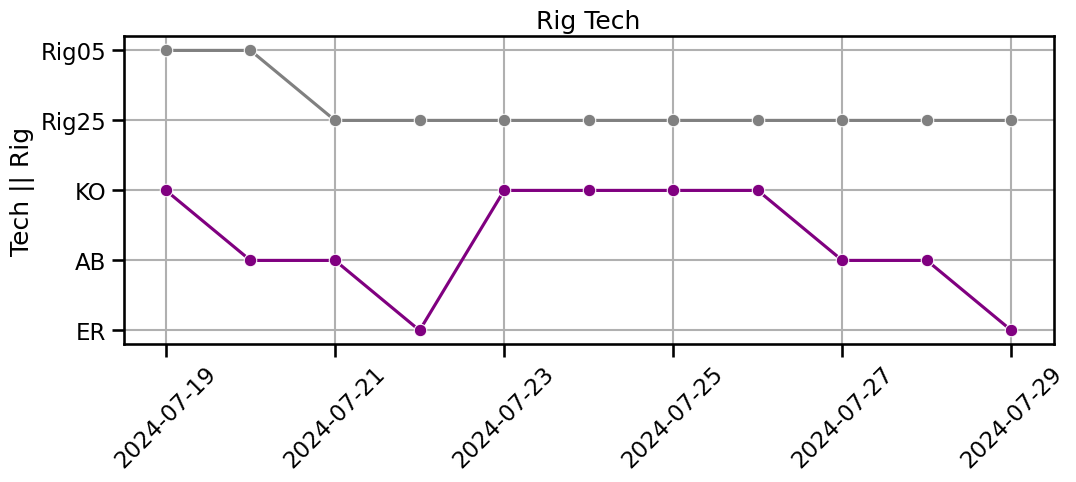

In [52]:
viz.plots.plot_rig_tech(days_df, ax=ax, title="Rig Tech", rotate_x_labels=rotate_x_labels)

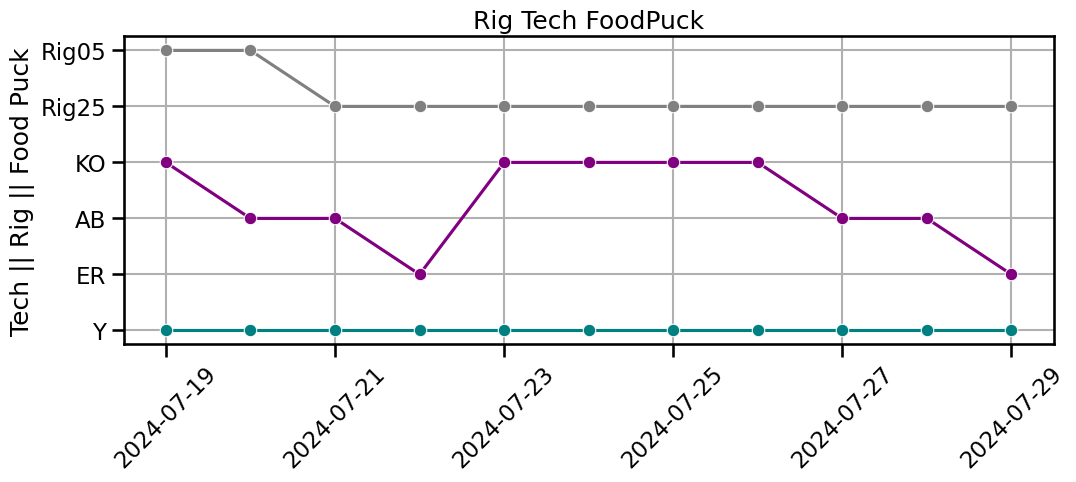

In [54]:
viz.plots.plot_rig_tech_foodpuck(
    days_df, ax=ax, title="Rig Tech FoodPuck", rotate_x_labels=rotate_x_labels
)


#### Cpoke Fix Stats

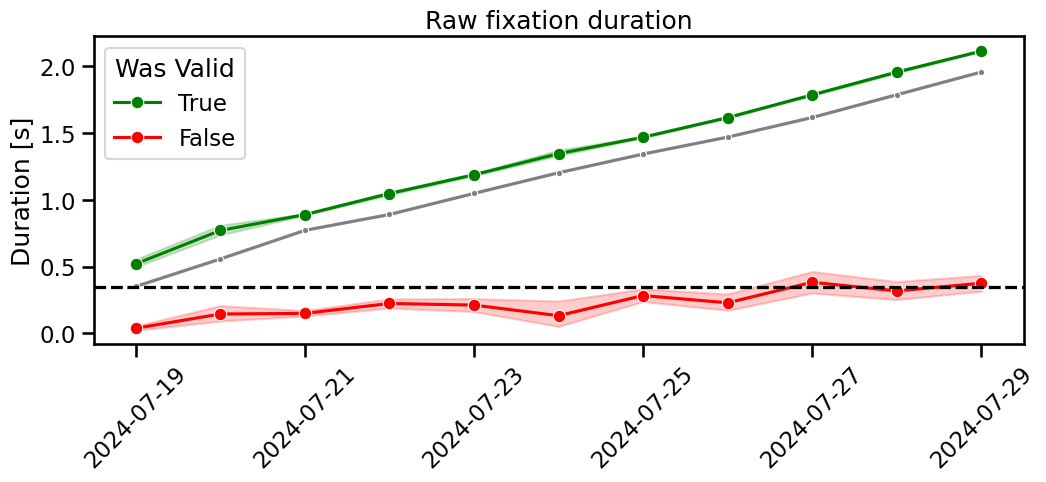

In [11]:
viz.FixationGrower.plots.plot_cpoke_fix_stats_raw(
    trials_df,
    title="Raw fixation duration",
    rotate_x_labels=True,
    legend=True,
)

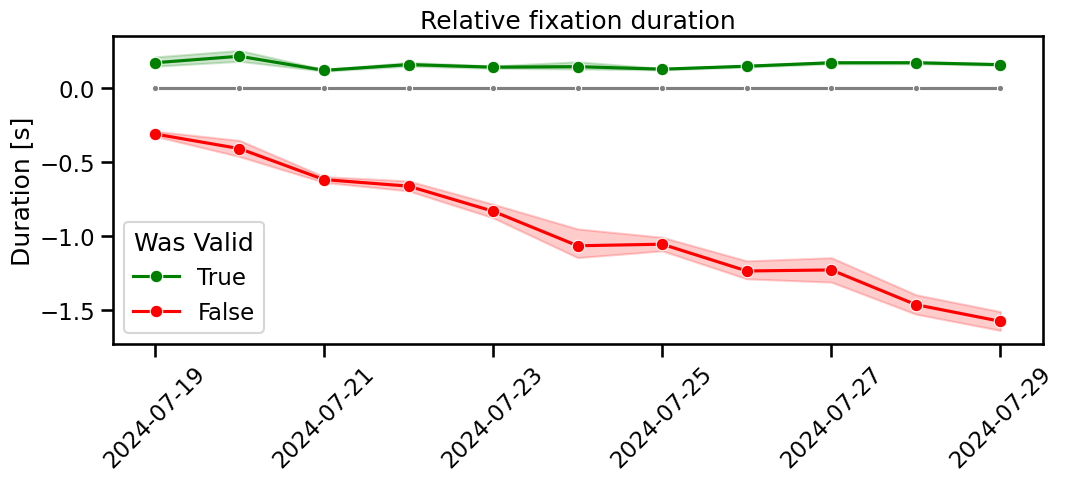

In [10]:
viz.FixationGrower.plots.plot_cpoke_fix_stats_relative(
    trials_df,
    title="Relative fixation duration",
    legend=True,
    rotate_x_labels=True,
)

NEXT STEPS:
1. Make an outline of plot and see what it looks like
- put in special FixationGrower multiplot case
- break and determinet the next informative plots to make (v1 or v2)- curriculum would be helpful for spoke too

---

In [125]:
from behav_viz.utils import plot_utils as pu


def plot_water_restriction(
    days_df,
    ax,
    title="",
    legend=True,
):
    """
    Plot the rig, pub and restriction target volume over date
    range in days_df

    params
    ------
    days_df : pd.DataFrame
        days dataframe with columns `date`, `rig_volume`, `pub_volume`
        and `volume_target` with dates as row index
    ax : matplotlib.axes.Axes
        axes to plot on
    title : str (optional, default = "")
        title for the plot
    legend : bool (optional, default = True)
        whether to include the legend or not
    xaxis_label : bool (optional, default = True)
        whether to include the xaxis label or not, this is useful when
        plotting multiple plots on the same figure
    """

    # stacked bar chart only works with df.plot (not seaborn)
    # if date is datetime convert to date only
    if days_df.date.dtype == "datetime64[ns]":
        days_df["date_only"] = days_df["date"].dt.date
        date_col = "date_only"
    else:
        date_col = "date"
    columns_to_plot = [date_col, "rig_volume", "pub_volume"]

    days_df[columns_to_plot].plot(
        x=date_col,
        kind="bar",
        stacked=True,
        color=["blue", "cyan"],
        ax=ax,
    )

    # iterate over dates to plot volume target black line
    for i, row in days_df.reset_index().iterrows():
        ax.hlines(y=row["volume_target"], xmin=i - 0.35, xmax=i + 0.35, color="black")
    pu.set_legend(ax, legend)
    ax.set(title=title, xlabel="", ylabel="Volume [mL]")

    return None


def plot_trials(days_df, ax=None, title="", legend=False):
    """
    Plot the number of trials completed and trial rate over
    date range in d_days_df

    params
    ------
    days_df : pd.DataFrame
        days dataframe with columns `date`, `n_done_trials`, `trial_rate` with
        dates as row index
    ax : matplotlib.axes.Axes
        axes to plot on
    title : str (optional, default = "")
        title for the plot
    legend : bool (optional, default = False)
        whether to include the legend or not
    """
    if ax is None:
        fig, ax = pu.make_fig()

    trial_melt = days_df.melt(
        id_vars=["date"],
        value_name="trial_var",
        value_vars=["n_done_trials", "trial_rate"],
    )
    sns.lineplot(
        data=trial_melt,
        x="date",
        y="trial_var",
        hue="variable",
        marker="o",
        ax=ax,
    )

    pu.set_legend(ax, legend)
    _ = ax.set(ylabel="Count || Per Hr", xlabel="", title=title)
    ax.set_ylim(bottom=0)
    ax.grid(alpha=0.5)

    return None


def ods(animal_id, animal_days_df, animal_trials_df):
    """
    params
    ------
    animal_id : str
        animal id to plot, e.g. "R610"
    days_df : pd.DataFrame
        days dataframe created by create_days_df_from_dj() with
        day as row index
    trials_df : pd.DataFrame
        trials dataframe created by create_trials_df_from_dj() with
        trial as row index

    """
    layout = """
        AAABBB
        """
    fig = plt.figure(constrained_layout=True, figsize=(20, 5))
    ax_dict = fig.subplot_mosaic(layout)  # ax to plot to
    plt.suptitle(f"{animal_id} Daily Summary Plot", fontweight="semibold")

    # final_row = ["A", "B", ]
    final_row = ["C"]
    bar_plot_axes = ["B"]

    ## ROW 1
    plot_trials(
        animal_days_df,
        ax_dict["A"],
        title="Trials",
        legend=True,
    )
    plot_water_restriction(
        animal_days_df, ax_dict["B"], title="Water Restriction", legend=True
    )

    for ax in ["A", "B"]:

        if ax in bar_plot_axes:
            date_labels = days_df["date"].unique()
            ax_dict[ax].set_xticks(range(len(date_labels)))
            if ax in final_row:
                ax_dict[ax].set_xticklabels(
                    [d.strftime("%Y-%m-%d") for d in date_labels], rotation=45
                )
            else:
                ax_dict[ax].set_xticklabels([])

        else:

            ax_dict[ax].set_xlim(
                animal_days_df["date"].min(), animal_days_df["date"].max()
            )
            ax_dict[ax].xaxis.set_major_locator(plt.MaxNLocator(integer=True))
            if ax in final_row:
                ax_dict[ax].tick_params(axis="x", rotation=45)
            else:
                ax_dict[ax].set_xticklabels([])

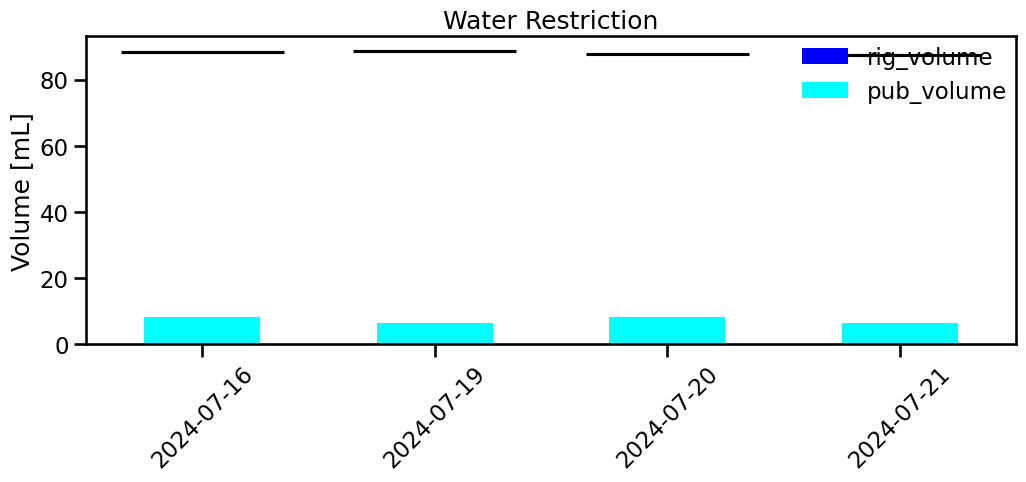

In [128]:
fig, ax = pu.make_fig()
plot_water_restriction(days_df, ax, title="Water Restriction", legend=True)
ax.tick_params(axis="x", rotation=45)

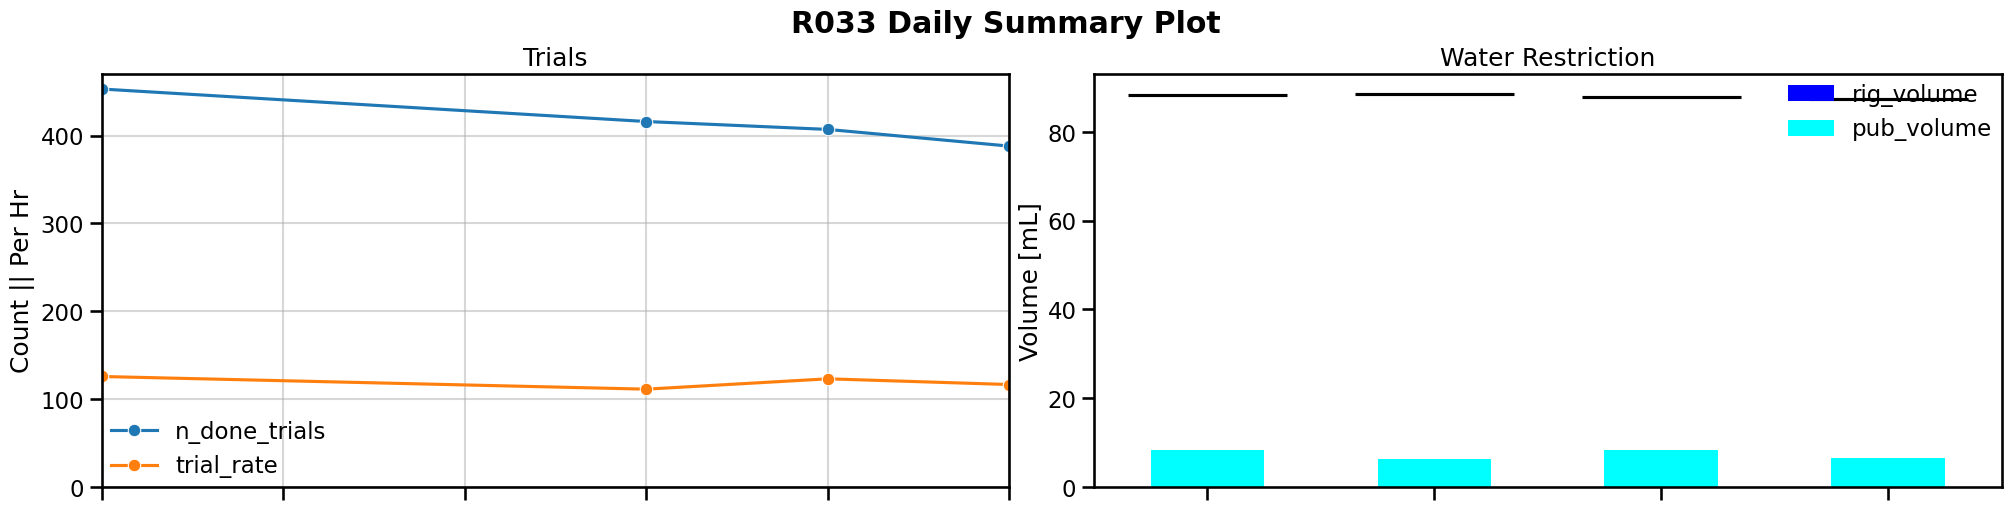

In [84]:
axdict = ods(animal_id, days_df, trials_df)

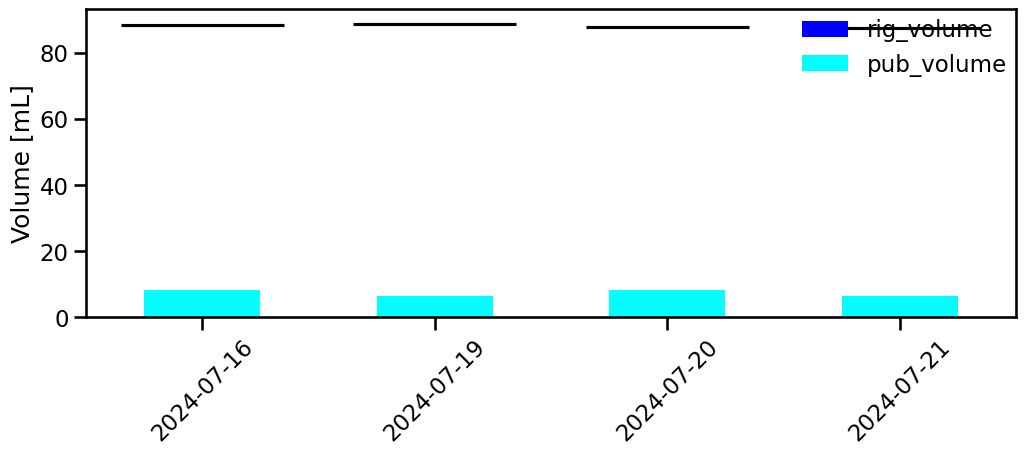

In [61]:
import matplotlib.dates as mdates

fig, ax = pu.make_fig()
viz.plot_days_info.plot_water_restriction(days_df, ax)
# xmin = mdates.date2num(days_df["date"].min())
# xmax = mdates.date2num(days_df["date"].max())
# ax.set_xlim(xmin, xmax)
# ax.set_xlim(days_df["date"].min(), days_df["date"].max())
import pandas as pd

# Convert dates to numerical values for setting limits
date_min = pd.to_datetime(days_df["date"].min()).date()
date_max = pd.to_datetime(days_df["date"].max()).date()
# ax.set_xlim(date_min, date_max)

This is a good starting spot- I have the data frame and now just need to make the folliwng:
* integrate creation of df into a cleaner function with a relative call
* use that function to make raw plot
    * add in aethetics (colors, order, legend, labels)
* use that function to make relative plot
* write bigger wrapper
    